In [1]:
import os
import warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore") 

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/14986.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/3138.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/1700.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/16257.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/2863.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/771.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/12167.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/17643.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/6560.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/10162.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/4009.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/15823.jpg
/kaggle/input/intel-image-classification/seg_tr

In [3]:
import os
print(os.listdir("/kaggle/input/intel-image-classification"))


['seg_train', 'seg_pred', 'seg_test']


In [4]:
print(sorted(os.listdir("/kaggle/input/intel-image-classification/seg_train/seg_train")))


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


# Intel Image Classification — CNN Projesi (Bootcamp)

Bu notebook; EDA → Eğitim → Değerlendirme → Grad-CAM → Hiperparametre deneyi
adımlarını içerir. Veri: **puneet6060/intel-image-classification** (6 sınıf).

1) Kurulum & Sabitler (Code)

In [5]:
import os, random, warnings, numpy as np, matplotlib.pyplot as plt, seaborn as sns
warnings.filterwarnings('ignore'); sns.set(style="whitegrid")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix

BASE      = "/kaggle/input/intel-image-classification"
TRAIN_DIR = f"{BASE}/seg_train/seg_train"
TEST_DIR  = f"{BASE}/seg_test/seg_test"

IMG_SIZE  = (128, 128)   
BATCH     = 32
EPOCHS    = 10          
SEED      = 42
AUTOTUNE  = tf.data.AUTOTUNE

random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

print("TF:", tf.__version__, "| GPU:", tf.config.list_physical_devices('GPU'))
print("Train klasörleri:", sorted(os.listdir(TRAIN_DIR)))


E0000 00:00:1758737894.950917      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758737895.048564      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TF: 2.18.0 | GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Train klasörleri: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


2) EDA — Sınıf Sayıları + Örnekler (Code)

Train toplam: 14034  | Test toplam: 3000


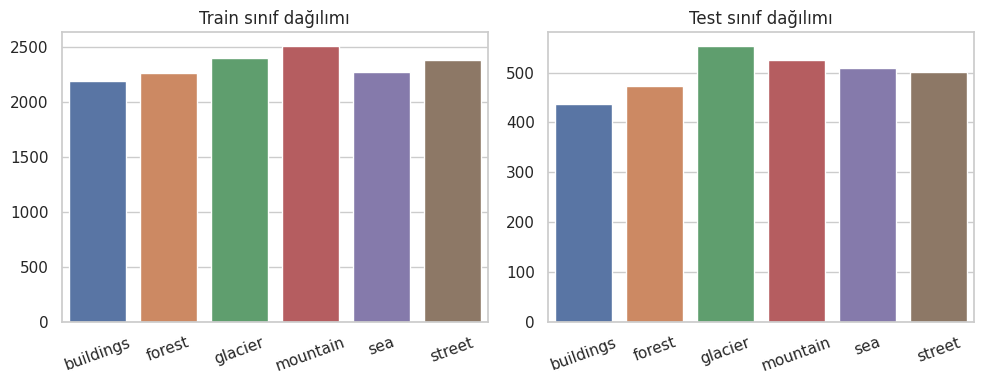

In [6]:
def count_images(folder):
    counts = {}
    for cls in sorted(os.listdir(folder)):
        p = os.path.join(folder, cls)
        if os.path.isdir(p):
            counts[cls] = len([f for f in os.listdir(p) if f.lower().endswith(('.jpg','.jpeg','.png'))])
    return counts

train_counts = count_images(TRAIN_DIR)
test_counts  = count_images(TEST_DIR)
print("Train toplam:", sum(train_counts.values()), " | Test toplam:", sum(test_counts.values()))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title("Train sınıf dağılımı"); plt.xticks(rotation=20)
plt.subplot(1,2,2); sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()))
plt.title("Test sınıf dağılımı"); plt.xticks(rotation=20)
plt.tight_layout(); plt.show()


Found 14034 files belonging to 6 classes.


I0000 00:00:1758737917.702481      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758737917.703283      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


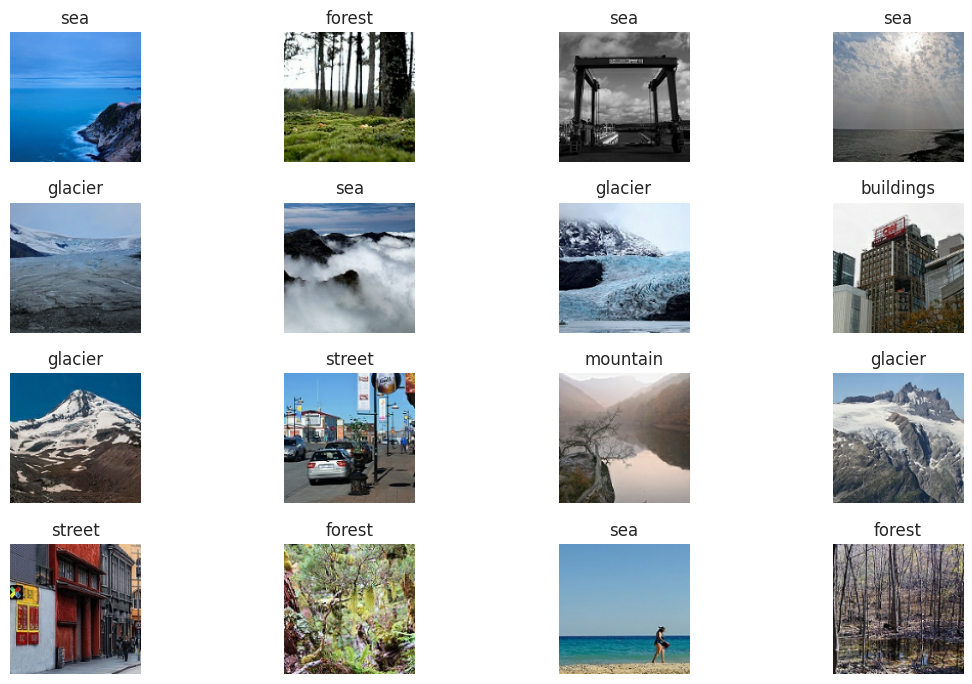

In [7]:
train_ds_preview = keras.utils.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMG_SIZE, batch_size=16, shuffle=True, seed=SEED, label_mode="int"
)
class_names = train_ds_preview.class_names; num_classes = len(class_names)
imgs, labs = next(iter(train_ds_preview))
plt.figure(figsize=(12,7))
for i in range(16):
    plt.subplot(4,4,i+1); plt.imshow(imgs[i].numpy().astype("uint8"))
    plt.title(class_names[int(labs[i])]); plt.axis("off")
plt.tight_layout(); plt.show()
del train_ds_preview  # sadece EDA için kullandık


3) Dataloader’lar (train / val / test) (Code)

In [8]:
train_ds = keras.utils.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH,
    validation_split=0.2, subset="training", seed=SEED, label_mode="int"
)
val_ds = keras.utils.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH,
    validation_split=0.2, subset="validation", seed=SEED, label_mode="int"
)
test_ds = keras.utils.image_dataset_from_directory(
    TEST_DIR, image_size=IMG_SIZE, batch_size=BATCH, shuffle=False, label_mode="int"
)

class_names = train_ds.class_names; num_classes = len(class_names)
train_ds = train_ds.prefetch(AUTOTUNE); val_ds = val_ds.prefetch(AUTOTUNE); test_ds = test_ds.prefetch(AUTOTUNE)
print("Sınıflar:", class_names)


Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.
Sınıflar: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


4) Model + Augmentation (Code)

In [9]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.10),
], name="data_aug")

def build_model(img_size=IMG_SIZE, num_classes=num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)
    x = data_augmentation(x)

    # Blok 1
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x); x = layers.Dropout(0.2)(x)

    # Blok 2
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x); x = layers.Dropout(0.3)(x)

    # Blok 3
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x); x = layers.Dropout(0.4)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="intel_cnn")
    return model

model = build_model()
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "intel_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_aug (Sequential)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,482,726 (17.10 MB)

 Trainable params: 4,482,470 (17.10 MB)

 Non-trainable params: 256 (1.00 KB)

5) Eğitim + Grafikler (Code)

Epoch 1/10


E0000 00:00:1758737934.468663      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/intel_cnn_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1758737936.202769      92 cuda_dnn.cc:529] Loaded cuDNN version 90300


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4669 - loss: 1.4129
Epoch 1: val_accuracy improved from -inf to 0.59907, saving model to best_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - accuracy: 0.4670 - loss: 1.4123 - val_accuracy: 0.5991 - val_loss: 0.9843 - learning_rate: 0.0010
Epoch 2/10
350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5992 - loss: 0.9995
Epoch 2: val_accuracy improved from 0.59907 to 0.66500, saving model to best_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.5993 - loss: 0.9994 - val_accuracy: 0.6650 - val_loss: 0.8395 - learning_rate: 0.0010
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6398 - loss: 0.9145
Epoch 3: val_accuracy improved from 0.66500 to 0.70634, saving model to best_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 23s 66ms/step - accuracy: 0.6398 - loss: 0.9145 - val_accuracy: 0.7063 - val_loss: 0.7641 - learning_rate: 0.0010
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - a

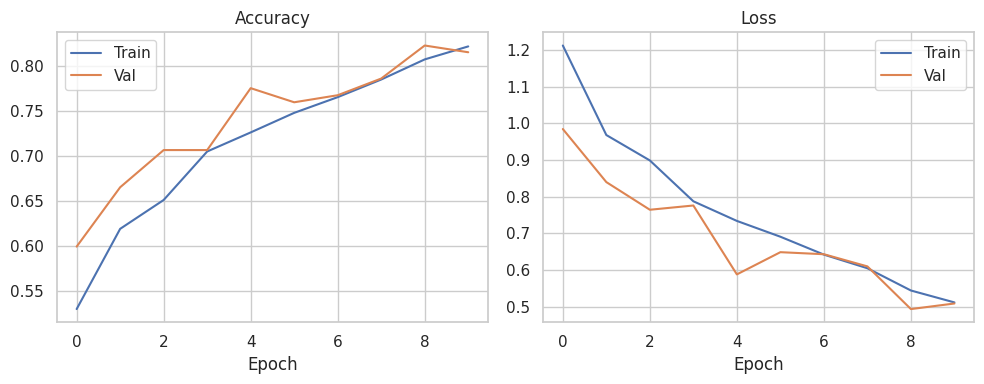

In [10]:
ckpt   = keras.callbacks.ModelCheckpoint("best_model.keras", monitor="val_accuracy",
                                         save_best_only=True, mode="max", verbose=1)
early  = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5,
                                       restore_best_weights=True, verbose=1)
reduce = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2,
                                           patience=3, min_lr=1e-5, verbose=1)

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS,
                    callbacks=[ckpt, early, reduce], verbose=1)

# Grafik
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(history.history["accuracy"]); plt.plot(history.history["val_accuracy"])
plt.title("Accuracy"); plt.xlabel("Epoch"); plt.legend(["Train","Val"]); plt.grid(True)
plt.subplot(1,2,2); plt.plot(history.history["loss"]); plt.plot(history.history["val_loss"])
plt.title("Loss"); plt.xlabel("Epoch"); plt.legend(["Train","Val"]); plt.grid(True)
plt.tight_layout(); plt.show()


6) Değerlendirme: Test, Report, Confusion Matrix (Code)

Test Loss: 0.4907 | Test Acc: 0.8300

Classification Report:

              precision    recall  f1-score   support

   buildings     0.8557    0.7872    0.8200       437
      forest     0.8345    0.9895    0.9054       474
     glacier     0.8307    0.7631    0.7955       553
    mountain     0.7864    0.7924    0.7894       525
         sea     0.8297    0.8882    0.8580       510
      street     0.8521    0.7705    0.8092       501

    accuracy                         0.8300      3000
   macro avg     0.8315    0.8318    0.8296      3000
weighted avg     0.8306    0.8300    0.8283      3000



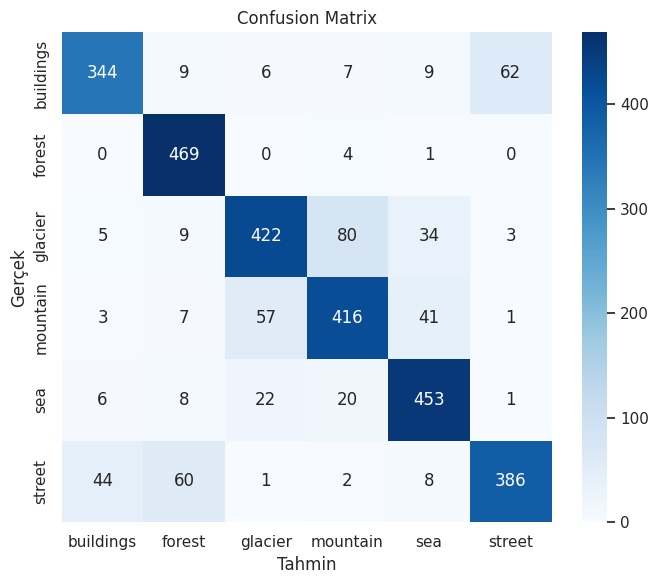

In [11]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

# Tahminler
y_true = np.concatenate([y.numpy() for _, y in test_ds])
y_pred_prob = model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix"); plt.ylabel("Gerçek"); plt.xlabel("Tahmin")
plt.tight_layout(); plt.show()


7) Grad-CAM (cv2’siz, sürüm bağımsız) (Code)

Last conv layer: conv2d_5


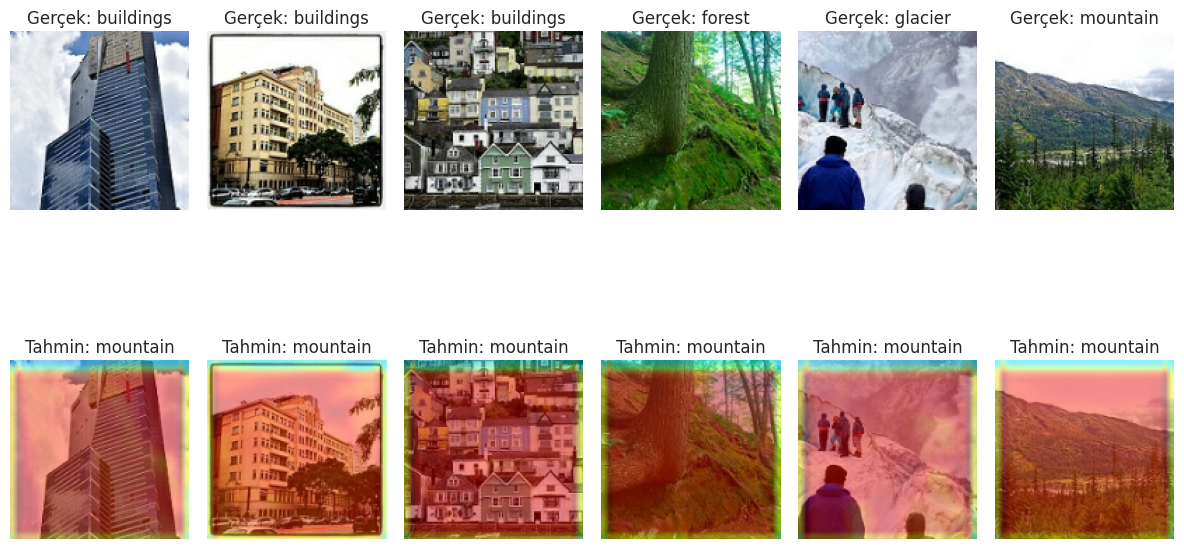

In [12]:
# Son konv katman adını bul
last_conv_name = None
for layer in reversed(model.layers):
    if isinstance(layer, layers.Conv2D):
        last_conv_name = layer.name; break
print("Last conv layer:", last_conv_name)

def make_gradcam_heatmap(img_uint8, model, last_conv_layer_name, pred_index=None):
    img = tf.cast(img_uint8, tf.float32) / 255.0
    grad_model = keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img[None, ...])
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_out = conv_out[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_out), axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / (np.max(heatmap) + 1e-8)
    return heatmap

def overlay_matplotlib(img_uint8, heatmap, alpha=0.4):
    # Matplotlib ile bindirme (cv2 gerekmez)
    from matplotlib import cm
    hmap = cm.jet(heatmap)[..., :3]   # RGBA->RGB
    hmap = (hmap * 255).astype(np.uint8)
    hmap = tf.image.resize(hmap, (img_uint8.shape[0], img_uint8.shape[1])).numpy().astype(np.uint8)
    blended = (alpha*hmap + (1-alpha)*img_uint8).astype(np.uint8)
    return blended

# 6 örnek göster
test_unbatched = test_ds.unbatch()
indices = [0, 50, 100, 500, 1000, 1500]
samples = []
cnt = 0
for i,(x,y) in enumerate(test_unbatched):
    if i in indices:
        samples.append((x.numpy().astype("uint8"), int(y.numpy())))
    cnt += 1
    if len(samples) == len(indices): break

plt.figure(figsize=(12,8))
for i,(img_uint8, tlabel) in enumerate(samples):
    heatmap = make_gradcam_heatmap(img_uint8, model, last_conv_name)
    vis = overlay_matplotlib(img_uint8, heatmap, alpha=0.45)
    pred = class_names[np.argmax(model.predict(img_uint8[None,...]/255.0, verbose=0))]
    plt.subplot(2,6,i+1); plt.imshow(img_uint8); plt.title(f"Gerçek: {class_names[tlabel]}"); plt.axis("off")
    plt.subplot(2,6,6+i+1); plt.imshow(vis); plt.title(f"Tahmin: {pred}"); plt.axis("off")
plt.tight_layout(); plt.show()


8) Mini Hiperparametre Deneyi (kaç epoch kısa) (Code)

E0000 00:00:1758738199.237110      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/intel_cnn_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1758738315.622937      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/intel_cnn_1/dropout_8_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1758738431.828365      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/intel_cnn_1/dropout_12_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


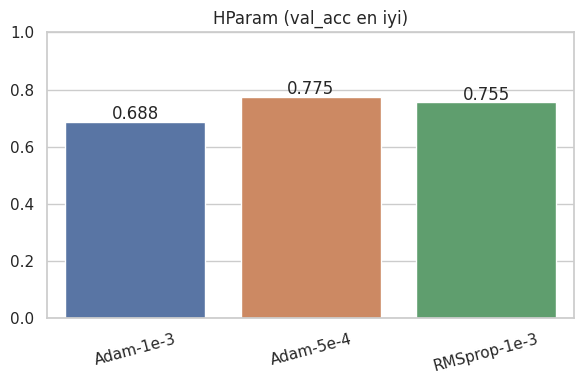

En iyi: Adam-5e-4 → 0.775124728679657


In [13]:
def try_optimizer(name, opt):
    m = build_model()
    m.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    h = m.fit(train_ds, validation_data=val_ds, epochs=5, verbose=0)
    return max(h.history["val_accuracy"])

trials = {
    "Adam-1e-3":    keras.optimizers.Adam(1e-3),
    "Adam-5e-4":    keras.optimizers.Adam(5e-4),
    "RMSprop-1e-3": keras.optimizers.RMSprop(1e-3),
}
results = {k: try_optimizer(k, v) for k,v in trials.items()}
plt.figure(figsize=(6,4))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("HParam (val_acc en iyi)"); plt.ylim(0,1); plt.xticks(rotation=15)
for i,(k,v) in enumerate(results.items()):
    plt.text(i, v+0.01, f"{v:.3f}", ha="center")
plt.tight_layout(); plt.show()
print("En iyi:", max(results, key=results.get), "→", results[max(results, key=results.get)])
